In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mobilenet_model = tf.keras.applications.MobileNetV2()
mobilenet_model.trainable = False

In [3]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image
def get_label(features):
    return tf.keras.applications.mobilenet_v2.decode_predictions(features, top=1)[0][0]

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
print(image)
features = mobilenet_model.predict(image)

tf.Tensor(
[[[[ 0.21712625  0.25683212 -0.2598346 ]
   [ 0.21268594  0.28474486 -0.20937276]
   [ 0.28137255  0.3803922  -0.10343134]
   ...
   [ 0.01257002  0.07531512 -0.37174374]
   [ 0.0419184   0.10466349 -0.35808164]
   [ 0.01515567  0.07790077 -0.39219737]]

  [[ 0.16701686  0.22731423 -0.29153317]
   [ 0.20507705  0.27767098 -0.22268909]
   [ 0.27753627  0.37744772 -0.12228638]
   ...
   [ 0.09616482  0.16461718 -0.29786307]
   [ 0.0660944   0.13454676 -0.33390558]
   [ 0.12299645  0.19144893 -0.2873435 ]]

  [[ 0.1211791   0.19268858 -0.30375636]
   [ 0.15968025  0.24595475 -0.27169228]
   [ 0.21157646  0.31304705 -0.20610559]
   ...
   [ 0.12801123  0.2064426  -0.26921284]
   [ 0.1727252   0.25115657 -0.22727484]
   [ 0.13919818  0.21762955 -0.276429  ]]

  ...

  [[-0.21489316 -0.16134608 -0.4903021 ]
   [-0.36116862 -0.27393347 -0.6042541 ]
   [-0.09921896  0.01733434 -0.31487077]
   ...
   [ 0.21523547  0.34620392  0.01868403]
   [ 0.2218225   0.36140263 -0.08099556]
   [-

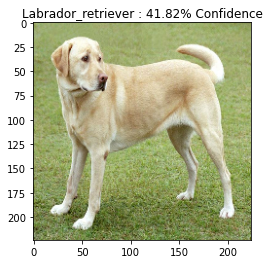

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_label(features)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def adv_image_gen(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = mobilenet_model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]]

 [[0. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]
  ...
  [0. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]]

 [[1. 0. 1.]
  [0. 0. 1.]
  [0. 0. 0.]
  ...
  [0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 1. 0.]
  [0. 0. 0.]
  [1. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 1.]]

 [[0. 0. 0.]
  [0. 0. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 0.]
  [0. 0. 0.]
  [0. 1. 1.]]

 [[0. 0. 1.]
  [1. 0. 1.]
  [1. 0. 0.]
  ...
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)


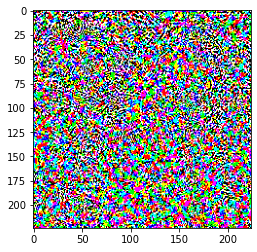

In [9]:
labrador_index = 208
label = tf.one_hot(labrador_index, features.shape[-1])
label = tf.reshape(label, (1, features.shape[-1]))
perturbations = adv_image_gen(image, label)
print(perturbations[0] * 0.5 + 0.5)
plt.imshow(perturbations[0] * 0.5 + 0.5);

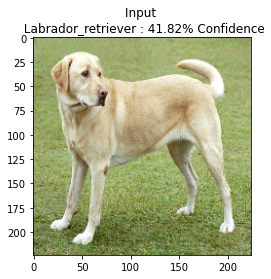

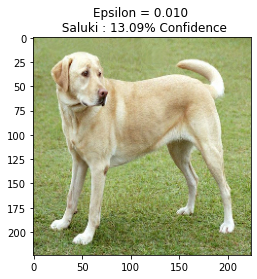

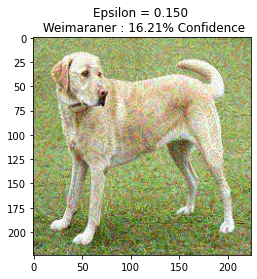

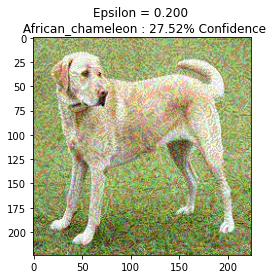

In [10]:
def display_images(image, description):
    _, label, confidence = get_label(mobilenet_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

epsilons = [0, 0.01, 0.15, 0.2]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])